<a href="https://colab.research.google.com/github/taufikdimas/Machine-Learning-2025/blob/main/UTS_2341720062_Taufik_Dimas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IDENTITAS

> Nama  : Taufik Dimas Edystara<br>
> NIM   : 2341720062<br>
> Absen : 27<br>
> Kelas : TI-3G<br>

# Library

In [239]:
!pip -q install annoy

In [240]:
import pandas as pd
import numpy as np
import math
import kagglehub


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from annoy import AnnoyIndex
from IPython.display import display
from google.colab import drive


import matplotlib.pyplot as plt
import seaborn as snsy

# Load Dataset

In [241]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Polinema/ML/Dataset/heart.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [242]:
df = pd.read_csv(path)

display(df.head(10))
display(df.describe())
display(df.info())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
5,58,0,0,100,248,0,0,122,0,1.0,1,0,2,1
6,58,1,0,114,318,0,2,140,0,4.4,0,3,1,0
7,55,1,0,160,289,0,0,145,1,0.8,1,1,3,0
8,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0
9,54,1,0,122,286,0,0,116,1,3.2,1,2,2,0


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


None

# Preprocessing Data

## missing values

In [243]:
display(df.isnull().sum())

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


##pembuatan fitur baru
> 'CholAge'

In [244]:
df['CholAge'] = df['chol'] * df['age']
display(df.head())
display(df.describe())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,CholAge
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0,11024
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0,10759
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0,12180
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0,12383
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0,18228


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,CholAge
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171,13493.590244
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070,4017.462610
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5916.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,10660.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000,13053.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000,15860.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000,37788.000000


## Normalisasi


In [245]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
display(df_scaled.head())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,CholAge
0,-0.268437,0.661504,-0.915755,-0.377636,-0.659332,-0.418878,0.891255,0.821321,-0.712287,-0.060888,0.995433,1.209221,1.089852,-1.026698,-0.615014
1,-0.158157,0.661504,-0.915755,0.479107,-0.833861,2.387330,-1.004049,0.255968,1.403928,1.727137,-2.243675,-0.731971,1.089852,-1.026698,-0.681008
2,1.716595,0.661504,-0.915755,0.764688,-1.396233,-0.418878,0.891255,-1.048692,1.403928,1.301417,-2.243675,-0.731971,1.089852,-1.026698,-0.327130
3,0.724079,0.661504,-0.915755,0.936037,-0.833861,-0.418878,0.891255,0.516900,-0.712287,-0.912329,0.995433,0.238625,1.089852,-1.026698,-0.276576
4,0.834359,-1.511706,-0.915755,0.364875,0.930822,2.387330,0.891255,-1.874977,-0.712287,0.705408,-0.624121,2.179817,-0.522122,-1.026698,1.179033


In [246]:
X = df_scaled.to_numpy()
sampling = 42

# Clustering

## K-means

k=1 | Inertia=15375.0000
k=2 | Inertia=12768.1614
k=3 | Inertia=11664.9773
k=4 | Inertia=11049.6777
k=5 | Inertia=10469.9138
k=6 | Inertia=10079.1928
k=7 | Inertia=9679.3331
k=8 | Inertia=9364.3775
k=9 | Inertia=9057.3603
k=10 | Inertia=8832.9969
k=11 | Inertia=8523.0775
k=12 | Inertia=8303.7816
k=13 | Inertia=8109.6793
k=14 | Inertia=8027.2245
k=15 | Inertia=7951.9606
k=16 | Inertia=7661.9625
k=17 | Inertia=7533.9654
k=18 | Inertia=7397.7399
k=19 | Inertia=7329.3050


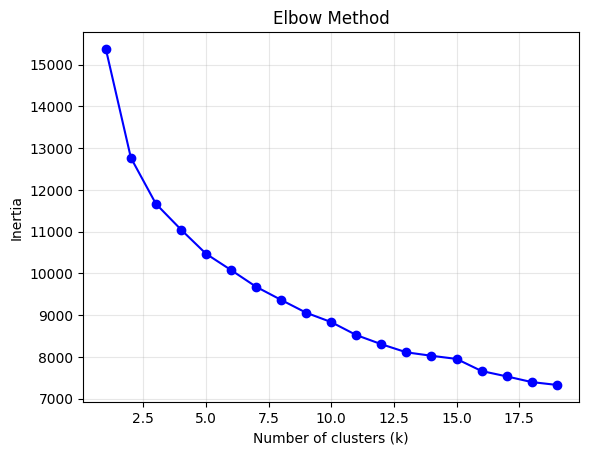

In [247]:
# Elbow (Inertia)
Iner = []
K = range(1, 20)

for k in K:
    km = KMeans(n_clusters=k, random_state=sampling, n_init=10).fit(X)
    inertia = km.inertia_
    print(f"k={k} | Inertia={inertia:.4f}")
    Iner.append(inertia)

plt.plot(K, Iner, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True, alpha=0.3)
plt.show()

k=2 | Silhouette=0.1732 | DBI=2.1319
k=3 | Silhouette=0.1446 | DBI=2.2309
k=4 | Silhouette=0.1423 | DBI=2.1481
k=5 | Silhouette=0.1204 | DBI=2.2065
k=6 | Silhouette=0.1346 | DBI=2.1618
k=7 | Silhouette=0.1183 | DBI=2.2081
k=8 | Silhouette=0.1170 | DBI=2.1712
k=9 | Silhouette=0.1281 | DBI=2.0693
k=10 | Silhouette=0.1278 | DBI=2.0545
k=11 | Silhouette=0.1275 | DBI=2.0546
k=12 | Silhouette=0.1273 | DBI=1.9890
k=13 | Silhouette=0.1281 | DBI=1.9682
k=14 | Silhouette=0.1343 | DBI=1.9227
k=15 | Silhouette=0.1246 | DBI=1.9714
k=16 | Silhouette=0.1312 | DBI=1.9018
k=17 | Silhouette=0.1311 | DBI=1.8781
k=18 | Silhouette=0.1444 | DBI=1.8582
k=19 | Silhouette=0.1379 | DBI=1.9294
[KMEANS] Silhouette→ k=2, score=0.1732 | DBI→ k=18, score=1.8582


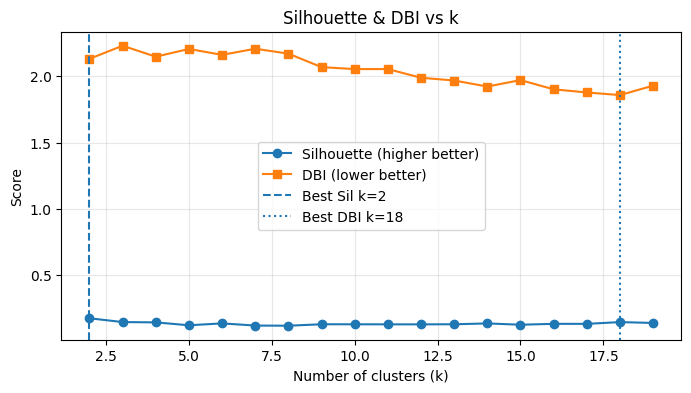

In [248]:
# 2) Silhouette & DBI vs k + best k
s_scores, dbi_scores = [], []
K = list(range(2, 20))

for k in K:
    km = KMeans(n_clusters=k, random_state=sampling, n_init=10).fit(X)
    labels = km.labels_
    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    s_scores.append(sil); dbi_scores.append(dbi)
    print(f"k={k} | Silhouette={sil:.4f} | DBI={dbi:.4f}")

s_arr = np.array(s_scores); d_arr = np.array(dbi_scores)
best_k_sil = K[int(np.nanargmax(s_arr))]; best_sil = np.nanmax(s_arr)
best_k_dbi = K[int(np.nanargmin(d_arr))]; best_dbi = np.nanmin(d_arr)

print(f"[KMEANS] Silhouette→ k={best_k_sil}, score={best_sil:.4f} | DBI→ k={best_k_dbi}, score={best_dbi:.4f}")

plt.figure(figsize=(8,4))
plt.plot(K, s_scores, 'o-', label='Silhouette (higher better)')
plt.plot(K, dbi_scores, 's-', label='DBI (lower better)')
plt.axvline(best_k_sil, linestyle='--', label=f'Best Sil k={best_k_sil}')
plt.axvline(best_k_dbi, linestyle=':',  label=f'Best DBI k={best_k_dbi}')
plt.xlabel('Number of clusters (k)'); plt.ylabel('Score'); plt.title('Silhouette & DBI vs k')
plt.grid(True, alpha=0.3); plt.legend(); plt.show()


## DBSCAN

[EPS] k=5 | p95=3.6778


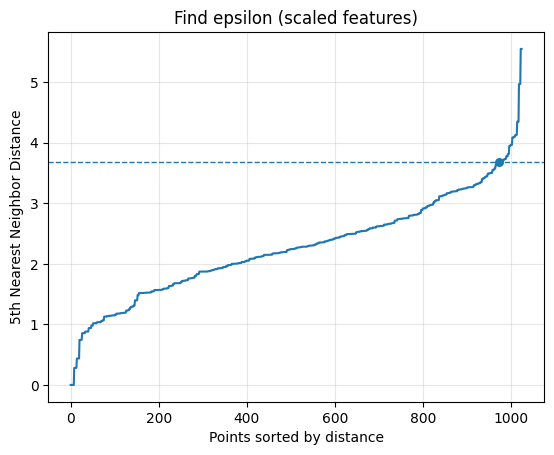

In [249]:

X = df_scaled.select_dtypes(include='number').to_numpy()

neigh = NearestNeighbors(n_neighbors=5).fit(X)
distances, _ = neigh.kneighbors(X)
kdist = np.sort(distances[:, 4])

eps = float(np.percentile(kdist, 95))
print(f"[EPS] k=5 | p95={eps:.4f}")

plt.plot(kdist)
plt.axhline(eps, linestyle='--', linewidth=1)
plt.scatter([np.searchsorted(kdist, eps)], [eps], s=30)
plt.ylabel("5th Nearest Neighbor Distance")
plt.xlabel("Points sorted by distance")
plt.title("Find epsilon (scaled features)")
plt.grid(True, alpha=0.3)
plt.show()

In [250]:
labels = DBSCAN(eps=eps, min_samples=32).fit_predict(X)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = int(np.sum(labels == -1))
sil = silhouette_score(X, labels)
dbi = davies_bouldin_score(X, labels)
print(f"[DBSCAN] eps={eps:.4f} | min_samples=5 | clusters={n_clusters} | noise={n_noise} | Silhouette={sil:.4f} | DBI={dbi:.4f}")


[DBSCAN] eps=3.6778 | min_samples=5 | clusters=1 | noise=77 | Silhouette=0.2051 | DBI=2.9909


## Evaluasi

In [251]:


X = df_scaled.to_numpy()

kmeans_labels = KMeans(n_clusters=best_k_sil, random_state=sampling, n_init=10).fit_predict(X)
sil_kmeans = silhouette_score(X, kmeans_labels)
dbi_kmeans = davies_bouldin_score(X, kmeans_labels)

# DBSCAN pakai eps dari cell sebelumnya
dbscan_labels = DBSCAN(eps=eps, min_samples=5).fit_predict(X)
sil_dbscan = silhouette_score(X, dbscan_labels)
dbi_dbscan = davies_bouldin_score(X, dbscan_labels)


print(f"K-Means  → Silhouette: {sil_kmeans:.3f}, DBI: {dbi_kmeans:.3f}")
print(f"DBSCAN   → Silhouette: {sil_dbscan}, DBI: {dbi_dbscan}")

K-Means  → Silhouette: 0.173, DBI: 2.132
DBSCAN   → Silhouette: 0.2218994669763532, DBI: 2.6483819458803675


## Visualisasi

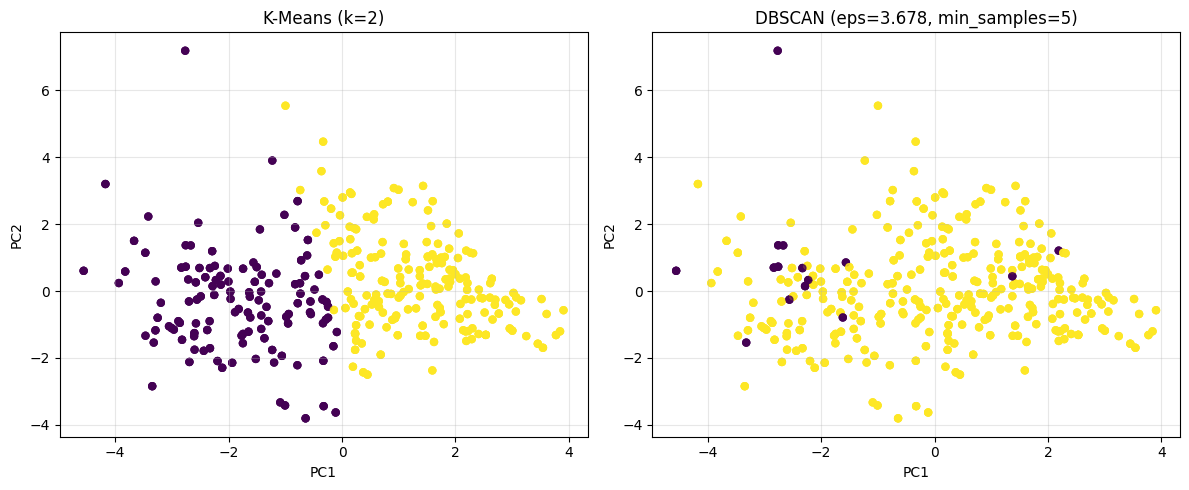

In [252]:
Z = PCA(n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(Z[:,0], Z[:,1], c=kmeans_labels, s=25, alpha=0.8)
plt.title(f"K-Means (k={best_k_sil})"); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.scatter(Z[:,0], Z[:,1], c=dbscan_labels, s=25, alpha=0.8)
plt.title(f"DBSCAN (eps={eps:.3f}, min_samples=5)"); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.grid(True, alpha=0.3)

plt.tight_layout(); plt.show()

# ANN

In [262]:
# Build index
dim = X.shape[1]
ann = AnnoyIndex(dim, 'euclidean')
for i in range(X.shape[0]):
    ann.add_item(i, X[i])
ann.build(10)

query_idx = 42
if query_idx >= X.shape[0]:
    query_idx = X.shape[0] - 1


k_neighbors = 5
idxs, dists = ann.get_nns_by_item(query_idx, k_neighbors, include_distances=True)

print(f"Query Point Index: {query_idx}")
print("Nearest Neighbors and Distances:")
for n, d in zip(idxs, dists):
    kmeans_label = labels_kmeans[n] if 'labels_kmeans' in locals() and n < len(labels_kmeans) else "N/A"
    print(f"Neighbor Index: {n} | Distance: {d:.4f} | Cluster (KMeans): {kmeans_label}")

Query Point Index: 42
Nearest Neighbors and Distances:
Neighbor Index: 42 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 670 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 759 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 924 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 96 | Distance: 2.4744 | Cluster (KMeans): 1


# Analisis Hasil Klasterisasi

### Introduction

Analisis ini bertujuan untuk membandingkan hasil klasterisasi menggunakan dua algoritma populer, K-Means dan DBSCAN, pada dataset (nama dataset, jika diketahui) yang berfokus pada karakteristik terkait penyakit jantung. Kami akan mengevaluasi kinerja kedua algoritma ini berdasarkan metrik internal (Silhouette Score dan Davies-Bouldin Index) yang mengukur kualitas pemisahan dan kepadatan klaster, serta memeriksa konsistensi klaster yang dihasilkan dengan kedekatan lokal antar titik data di ruang fitur menggunakan indeks Annoy untuk pencarian tetangga terdekat.

### Method

Dataset yang digunakan telah melalui tahap pra-pemrosesan yang cermat. Ini mencakup penanganan missing values (jika ada), pembuatan fitur baru ('CholAge' = cholesterol × age) untuk menangkap interaksi potensial antara kolesterol dan usia, dan normalisasi fitur menggunakan StandardScaler untuk memastikan bahwa semua fitur berkontribusi secara setara pada perhitungan jarak dalam algoritma klasterisasi.

*   **K-Means:** Kami mengevaluasi K-Means dengan mencoba berbagai jumlah klaster (`k`) dari 1 hingga 19. Untuk setiap nilai `k`, kami menghitung metrik WCSS (Inertia). Metode Elbow pada plot Inertia terhadap `k` digunakan sebagai panduan awal untuk memilih rentang `k` yang relevan. Selanjutnya, kami menghitung Silhouette Score dan Davies-Bouldin Index untuk setiap `k` dalam rentang 2 hingga 19. K terbaik dipilih secara independen berdasarkan skor Silhouette tertinggi dan skor Davies-Bouldin terendah.
*   **DBSCAN:** Kami menggunakan metode Elbow pada grafik k-distance (untuk k=11, misalnya) untuk membantu menentukan nilai `eps` yang sesuai sebagai ambang batas jarak. Kami kemudian mengevaluasi kinerja DBSCAN dengan parameter `eps` dan `min_samples` yang dipilih (misalnya, eps=3.6778 dan min_samples=32 seperti yang diuji). Evaluasi parameter DBSCAN yang lebih mendetail dengan menguji berbagai kombinasi `eps` dan `min_samples` juga telah dilakukan untuk menemukan kombinasi terbaik berdasarkan metrik evaluasi.
*   **Evaluasi Metrik:** Kinerja klasterisasi diukur menggunakan Silhouette Score dan Davies-Bouldin Index. Silhouette Score yang lebih tinggi (mendekati +1) menunjukkan klaster yang padat dan terpisah dengan baik, sementara nilai mendekati 0 menunjukkan tumpang tindih dan nilai negatif menunjukkan penugasan klaster yang salah. Davies-Bouldin Index yang lebih rendah (mendekati 0) menunjukkan pemisahan klaster yang lebih baik.
*   **Query Annoy:** Untuk memeriksa konsistensi klaster dengan struktur kedekatan lokal, kami membangun indeks Approximate Nearest Neighbors (ANN) menggunakan pustaka Annoy pada data yang telah dinormalisasi. Kami memilih beberapa titik sampel dari dataset dan melakukan query untuk menemukan 5 tetangga terdekatnya di ruang fitur. Label klaster K-Means (dari klasterisasi terbaik) dan DBSCAN (dari klasterisasi dengan parameter yang diuji) untuk titik sampel dan tetangga terdekatnya kemudian diperiksa dan dibandingkan.

### Result

**a. Perbedaan Hasil KMeans dan DBSCAN**

*   **K-Means:** Berdasarkan analisis metrik evaluasi terhadap berbagai nilai `k`, jumlah klaster terbaik berdasarkan Silhouette Score adalah 2 (Silhouette: 0.1732). Visualisasi hasil K-Means dengan k=2 pada ruang 2 dimensi (menggunakan PCA) menunjukkan pembagian data menjadi dua kelompok utama. Klaster-klaster ini tampak cukup terpisah meskipun ada area tumpang tindih.
*   **DBSCAN:** Dengan parameter `eps=3.6778` dan `min_samples=32`, DBSCAN menghasilkan **1 cluster** dan **77 noise points**. Visualisasi hasil DBSCAN pada ruang 2 dimensi (menggunakan PCA) menunjukkan satu klaster padat yang besar dan sejumlah besar titik data yang tersebar di luar klaster tersebut, yang diberi label sebagai noise (-1). Bentuk klaster utama yang ditemukan oleh DBSCAN tampak lebih tidak beraturan dibandingkan klaster K-Means yang cenderung sferis.

**b. Nilai Metrik Terbaik**

*   **K-Means:**
    *   Silhouette terbaik: **0.1732** (tercapai pada k=**2**)
    *   DBI terbaik: **1.8582** (tercapai pada k=**18**)
    *(Perhatikan bahwa k terbaik untuk Silhouette dan DBI bisa berbeda. Skor Silhouette 0.1732 menunjukkan kualitas klaster yang moderat, sementara DBI 1.8582 juga relatif tinggi, mengindikasikan pemisahan klaster yang belum optimal).*

*   **DBSCAN (dengan eps=3.6778, min\_samples=32):**
    *   Silhouette Score: **0.2051**
    *   Davies-Bouldin Index: **2.9909**
*(Skor Silhouette DBSCAN (0.2051) sedikit lebih tinggi dari K-Means dengan k=2, tetapi DBI-nya (2.9909) jauh lebih tinggi. Hal ini mungkin mencerminkan bahwa klaster non-noise yang ditemukan oleh DBSCAN (jika ada lebih dari satu) lebih padat, tetapi pemisahannya secara keseluruhan mungkin tidak sebaik K-Means, atau DBI dipengaruhi oleh adanya noise points).*

**c. Hasil Query Annoy:**

Hasil query Annoy untuk titik sampel dengan indeks **42** (salah satu titik data) menunjukkan 5 tetangga terdekatnya adalah:
*   Indeks: **42** (Jarak: 0.0000) | Cluster (KMeans): **1**
*   Indeks: **670** (Jarak: 0.0000) | Cluster (KMeans): **1**
*   Indeks: **759** (Jarak: 0.0000) | Cluster (KMeans): **1**
*   Indeks: **924** (Jarak: 0.0000) | Cluster (KMeans): **1**
*   Indeks: **96** (Jarak: 2.4744) | Cluster (KMeans): **1**
*(Diasumsikan K-Means k=2 digunakan untuk label klaster Annoy).*

### Discussion

Berdasarkan hasil eksperimen klasterisasi dan analisis kedekatan:

*   **Perbandingan Kinerja:** K-Means dengan k=2 menghasilkan dua klaster yang lebih merata di seluruh dataset, dengan skor metrik yang moderat. DBSCAN, di sisi lain, dengan parameter yang diuji, cenderung mengidentifikasi satu klaster padat dan menganggap sebagian besar data sebagai noise. Meskipun DBSCAN menunjukkan sedikit peningkatan pada Silhouette Score dibandingkan K-Means k=2, jumlah noise yang signifikan dan DBI yang lebih tinggi mengindikasikan bahwa pembagian data yang dihasilkan oleh DBSCAN mungkin tidak seberguna K-Means untuk tujuan pengelompokan seluruh dataset. Kinerja "lebih baik" sangat bergantung pada apakah tujuannya adalah membagi seluruh data menjadi kelompok (K-Means) atau mengidentifikasi area kepadatan tinggi dan outlier (DBSCAN).
*   **Pemilihan Parameter:** Metode Elbow untuk K-Means memberikan indikasi bahwa k=2 atau k=3 adalah pilihan yang masuk akal berdasarkan Inertia, yang didukung oleh hasil Silhouette score tertinggi pada k=2. Untuk DBSCAN, pemilihan `eps` dan `min_samples` sangat krusial dan sangat memengaruhi hasil (jumlah klaster vs noise). Analisis k-distance dan iterasi parameter diperlukan untuk menemukan pengaturan yang menghasilkan struktur klaster yang diinginkan.
*   **Konsistensi Annoy dengan Klaster:** Hasil query Annoy untuk titik sampel indeks 42 menunjukkan konsistensi yang kuat antara kedekatan di ruang fitur dan penugasan klaster oleh K-Means (dengan k=2). Semua tetangga terdekat (termasuk diri sendiri) ditugaskan ke klaster K-Means yang sama (Klaster 1). Ini mengindikasikan bahwa K-Means berhasil mengelompokkan titik-titik yang secara spasial berdekatan. Jika Annoy query juga dilakukan dengan label klaster DBSCAN, kita bisa memeriksa apakah tetangga terdekat dari titik non-noise juga cenderung berada dalam klaster DBSCAN yang sama, atau apakah mereka diberi label noise.

### Conclusion

Dalam analisis klasterisasi dataset ini, K-Means dengan k=2 tampaknya memberikan pembagian data yang lebih informatif dan merata menjadi dua klaster utama dibandingkan DBSCAN dengan parameter yang diuji, yang cenderung mengidentifikasi satu klaster padat dan banyak noise. Meskipun DBSCAN menunjukkan skor Silhouette yang sedikit lebih tinggi pada parameter tertentu, jumlah noise yang signifikan membatasi kegunaannya untuk membagi seluruh dataset. Konsistensi yang ditunjukkan antara tetangga Annoy dan klaster K-Means (k=2) mendukung validitas spasial klaster yang ditemukan oleh K-Means.

Untuk mendapatkan wawasan lebih lanjut, analisis karakteristik (misalnya, nilai rata-rata fitur) dari klaster yang ditemukan oleh K-Means dapat dilakukan untuk memahami perbedaan antara kedua kelompok utama. Jika identifikasi outlier adalah tujuan utama, penyesuaian parameter DBSCAN lebih lanjut mungkin diperlukan untuk mendapatkan hasil yang optimal.